## Importing the data for model training

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # AlexNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = datasets.ImageFolder('./data/ImgData/IotNetworkIntrusionDataset/Big', transform=transform)

# Perform train-test-valid split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# test_size = int(0.1 * len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [2]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 625783
    Root location: ./data/ImgData/IotNetworkIntrusionDataset/Big
    StandardTransform
Transform: Compose(
               Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [3]:
print(train_loader)

In [4]:
import matplotlib.pyplot as plt

In [5]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 227, 227])
Labels batch shape: torch.Size([32])


### Sample Train Data

C:\Users\aousa\AppData\Local\Temp\ipykernel_19064\3141201390.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3641.)
  img_data.append(img.T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


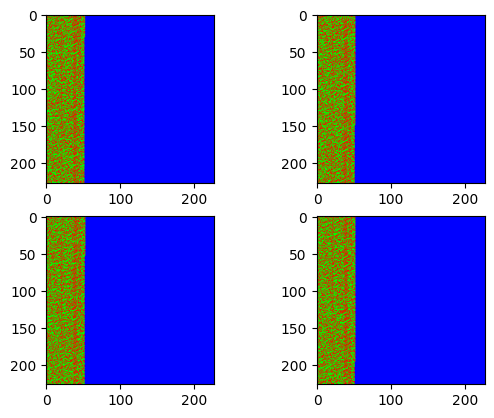

In [6]:
display_img_no = 4
# define 2x2 graphics 
f, axarr = plt.subplots(2, 2)
img_data = []
for i in range(display_img_no):
    img = train_features[i].squeeze()
    label = train_labels[i]
    img_data.append(img.T)
    # plt.imshow(img.T)
    # plt.show()
axarr[0,0].imshow(img_data[0])
axarr[0,1].imshow(img_data[1])
axarr[1,0].imshow(img_data[2])
axarr[1,1].imshow(img_data[3])

## Implementing pre-trained model 

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


### Load pre-trained AlexNet Model

In [8]:
import torchvision.models as models
# Load pre-trained AlexNet model
model = models.resnet18(pretrained=True)

D:\03_Projects\18_btp_minor_6\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\03_Projects\18_btp_minor_6\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Shift to using CUDA GPU

In [9]:
if torch.cuda.is_available():
    model.cuda()

### Modify Output Layer

In [10]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

In [13]:
import torch.nn as nn
# Replace the last layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming we are training for 2 classes


In [14]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Define loss function and Optimizer

In [15]:
# Define a loss function and an optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)


### Trace losses for each epochs

In [16]:
# To keep track of loss
train_losses = []
accuracy_losses = []

### Train the model

In [17]:
num_epochs = 5  # Choose number of epochs
if torch.cuda.is_available():
    model.cuda()
    
for epoch in range(num_epochs):
    # Training
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    train_losses.append(train_loss)

    # save model on each epochs
    torch.save(model, f'partial_alexnet_e{epoch}.pt')
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.4701
Epoch [2/5], Loss: 0.4246
Epoch [3/5], Loss: 0.0237
Epoch [4/5], Loss: 0.1687
Epoch [5/5], Loss: 0.1015


### Model Summary

In [18]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Graph Plots

### Plot the training and validation losses

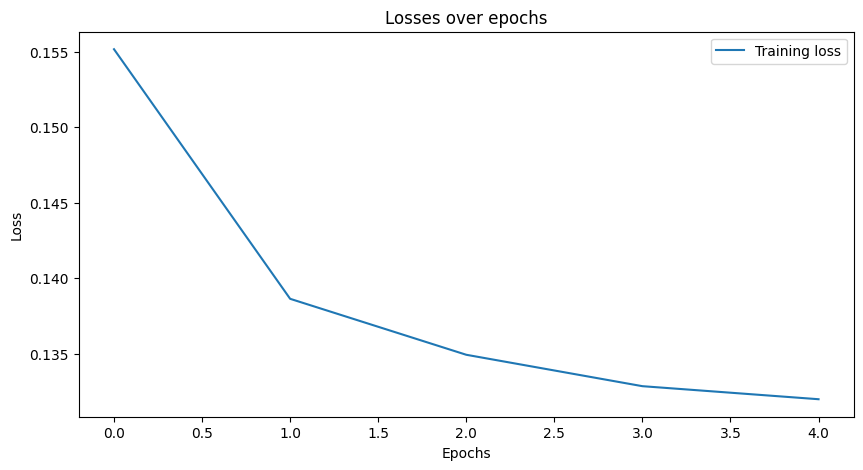

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.title('Losses over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# AlexNet Testing Implementation

This code is used to test AlexNet against the imported dataset and get the accuracy

In [20]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 227, 227])
Labels batch shape: torch.Size([32])


### Make the model go to eval mode

In [21]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
correct_count, all_count = 0, 0
tn, fp, fn, tp = 0, 0, 0, 0
print("Please wait while all images are being tested.....")
for images,labels in test_loader:
  for i in range(len(labels)):
    img = images[i].view(1, 3, 227, 227).to(device)
    with torch.no_grad():
        logps = model(img)

    ps = torch.exp(logps).cpu().data
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
        correct_count += 1
        if true_label == 1:
            tp += 1  # True positive: correctly predicted as class 1
        else:
            tn += 1  # True negative: correctly predicted as class 0
    else:
        if true_label == 1:
            fn += 1  # False negative: incorrectly predicted as class 0
        else:
            fp += 1  # False positive: incorrectly predicted as class 1

    all_count += 1

print("Number Of Images Tested =", all_count)
print("Number Of Correct Images", correct_count)
print("Number of Incorrect Images", all_count - correct_count)
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print("\nModel Accuracy =", (correct_count/all_count))

Please wait while all images are being tested.....
Number Of Images Tested = 125157
Number Of Correct Images 119680
Number of Incorrect Images 5477
True Positives: 115631
True Negatives: 4049
False Positives: 3920
False Negatives: 1557

Model Accuracy = 0.9562389638613901


### Confusion Matrix

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


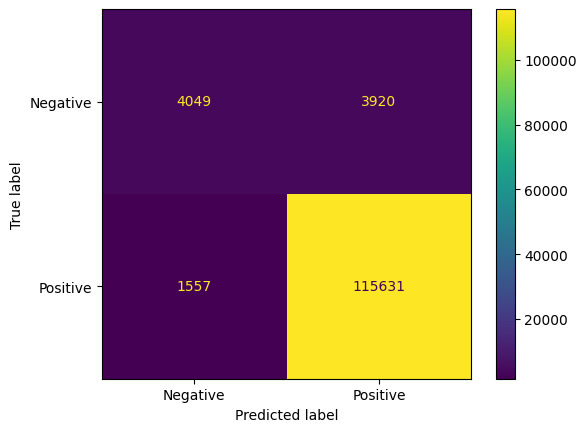

In [24]:
# Create the confusion matrix
cm = np.array([[tn, fp],
               [fn, tp]])

# Create a confusion matrix display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

# Plot the confusion matrix
disp.plot(cmap='viridis')
plt.show()

In [25]:
# Assuming precision, recall, f1_score, and accuracy are already defined
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)
accuracy = (tp + tn) / (tp + tn + fp + fn)

print(f"Precision: {precision}")
print(f"recall: {recall}")
print(f"f1_score: {f1_score}")
print(f"accuracy: {accuracy}")

Precision: 0.9672106465023296
recall: 0.9867136566883982
f1_score: 0.9768648173727184
accuracy: 0.9562389638613901


### Save the model

In [11]:
# Only Saves the model image, The model needs to rebuild before using 
torch.save(model.state_dict(), f'alexnet_e{num_epochs}.pth')

In [26]:
#Save entire model
torch.save(model, f'complete_resnet_e{num_epochs}.pt')